In [15]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches

In [16]:
N = 100
THETA = 3
BETA = 0.95

In [17]:
def cdf_inverse(Fx, theta=THETA):
    return ((-Fx+1) ** (-1/(theta-1))).astype(float)


def generate_sample(n=N, theta=THETA, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    Fx = np.random.sample(n)
    return cdf_inverse(Fx, theta)


sample = generate_sample(random_state=42)
print('sample =', sample)

sample = [1.26444595 4.50442711 1.93164669 1.57849408 1.08851288 1.08849733
 1.03037147 2.73358909 1.58334718 1.85081305 1.01045392 5.76484771
 2.44297063 1.12675725 1.10554618 1.10661489 1.1988669  1.45058064
 1.32679802 1.18781026 1.605099   1.07801056 1.18857814 1.25625944
 1.35590258 2.15753854 1.11780611 1.43478438 1.56635672 1.02406697
 1.59626498 1.09798933 1.03420391 4.42311366 5.39415075 2.2845425
 1.19918712 1.05273197 1.77957644 1.33648819 1.06724026 1.40744164
 1.01765083 3.32081901 1.1615193  1.72138276 1.20535399 1.44347795
 1.48529276 1.10759866 5.7339438  2.10880764 4.06554258 3.08353294
 1.57700457 3.57769125 1.04741762 1.11523746 1.02341081 1.21745917
 1.27898289 1.17149443 2.41640025 1.24684143 1.17927686 1.47875947
 1.07890763 2.24845159 1.03949803 8.73268751 2.0953946  1.11713762
 1.00277255 2.32785767 1.84697276 1.92097228 2.09092649 1.03921397
 1.24850438 1.06351031 2.70273652 1.6293002  1.22251401 1.03337902
 1.20471639 1.21732656 1.92309889 1.66104127 2.9776248

In [18]:
def calc_quantiles(beta):
    erfinv = sp.special.erfinv
    u1 = 2**0.5 * erfinv(-beta)
    u2 = -u1
    return u1, u2


def median_asymptotic_confidence_interval(sample, beta=BETA, precision=3):
    n = np.size(sample)
    theta_est = n / np.sum(np.log(sample)) + 1
    u1, u2 = calc_quantiles(beta)
    t1 = (u1 * 2**(1/(theta_est-1)) * np.log(2)) / ((theta_est-1) * n**0.5) + 2**(1/(theta_est-1))
    t2 = (u2 * 2**(1/(theta_est-1)) * np.log(2)) / ((theta_est-1) * n**0.5) + 2**(1/(theta_est-1))
    return round(t1, precision), round(t2, precision)


t1, t2 = median_asymptotic_confidence_interval(sample)
print(f'Asymptotic Confidence Interval for median = ({t1}, {t2})')
print(f'Real median = {round(np.median(sample), 3)}')

Asymptotic Confidence Interval for median = (1.288, 1.458)
Real median = 1.366


In [19]:
all_intervals = []

In [20]:
def target_function_f(x):
    N_LOCAL = np.size(sample)
    return (x-1)**N_LOCAL * np.exp(1-x) * np.prod(1/sample**x)


def get_normalising_constant(target_function, a, b):
    return 1 / sp.integrate.quad(target_function, a, b)[0]

def bayesian_credible_interval(sample, beta=BETA, precision=3):
    theta_min = 1
    theta_max = np.inf
    c = get_normalising_constant(target_function_f, theta_min, theta_max)
    res_1 = (1-beta)/2 / c
    res_2 = (1 - (1-beta)/2) / c
    cuts = int(10e3)
    max_quantile = int(THETA * 5)
    t_1 = np.inf
    delta = np.inf
    for quantile_i in np.linspace(theta_min, max_quantile, cuts):
        res_i = sp.integrate.quad(target_function_f, theta_min, quantile_i)[0]
        if abs(res_i - res_1) < delta:
            delta = abs(res_i - res_1)
            t_1 = quantile_i
    t_2 = np.inf
    delta = np.inf
    for quantile_i in np.linspace(theta_min, max_quantile, cuts):
        res_i = sp.integrate.quad(target_function_f, quantile_i, theta_max)[0]
        if abs(res_i - res_1) < delta:
            delta = abs(res_i - res_1)
            t_2 = quantile_i
    return round(t_1, precision), round(t_2, precision)


t_1, t_2 = bayesian_credible_interval(sample)
print(f'Bayesian Credible Interval = ({t_1}, {t_2})')

all_intervals.append((t_1, t_2))

<ipython-input-20-e433992fe095>:3: RuntimeWarning: overflow encountered in power
  return (x-1)**N_LOCAL * np.exp(1-x) * np.prod(1/sample**x)


Bayesian Credible Interval = (2.763, 3.6)


In [21]:
def calc_quantiles(beta):
    erfinv = sp.special.erfinv
    u1 = 2**0.5 * erfinv(-beta)
    u2 = -u1
    return u1, u2


def asymptotic_confidence_interval_omm(sample, beta=BETA, precision=3):
    n = np.size(sample)
    a1 = np.mean(sample)
    a2 = np.dot(sample, sample) / n
    u1, u2 = calc_quantiles(beta)
    t1 = (u1 * (a2-a1**2)**0.5 / ((a1-1)**2 * n**0.5)) + 2 + 1/(a1-1)
    t2 = (u2 * (a2-a1**2)**0.5 / ((a1-1)**2 * n**0.5)) + 2 + 1/(a1-1)
    return round(t1, precision), round(t2, precision)

def asymptotic_confidence_interval_omp(sample, beta=BETA, precision=3):
    n = np.size(sample)
    theta_est = n / np.sum(np.log(sample)) + 1
    u1, u2 = calc_quantiles(beta)
    t1 = u1 * (theta_est-1)/(n**0.5) + theta_est
    t2 = u2 * (theta_est-1)/(n**0.5) + theta_est
    return round(t1, precision), round(t2, precision)


t1_omm, t2_omm = asymptotic_confidence_interval_omm(sample)
print(f'Asymptotic Confidence Interval[OMM] = ({t1_omm}, {t2_omm})')
t1_omp, t2_omp = asymptotic_confidence_interval_omp(sample)
print(f'Asymptotic Confidence Interval[OMP] = ({t1_omp}, {t2_omp}) CANNOT BE USED!!!')

all_intervals.extend([(t1_omm, t2_omm), (t1_omp, t2_omp)])

Asymptotic Confidence Interval[OMM] = (2.876, 3.616)
Asymptotic Confidence Interval[OMP] = (2.758, 3.615) CANNOT BE USED!!!


In [22]:
# OMP
def est_1(sample):
    n = np.size(sample)
    return 1 + n/(np.sum(np.log(sample)))


# Bayesian
def est_2(sample):
    n = np.size(sample)
    return 1 + n/(1 + np.sum(np.log(sample)))


# OMM
def est_3(sample):
    return 2 + 1/(np.mean(sample) - 1)


n_est = np.array([est_1, est_2, est_3])
n_est_formula = [r'\frac{1}{\sum_{i=1}^{n}ln(x_i)}+1',
                 r'\frac{1}{\sum_{i=1}^{n}ln(x_i)+1}+1',
                 r'\frac{1}{\overline{x}-1}+2']

print(f'Estimates: {"; ".join([f"est_{i+1}={round(est(sample), 3)}" for i, est in enumerate(n_est)])}')

Estimates: est_1=3.186; est_2=3.14; est_3=3.246


In [23]:
def bootstrap_confidence_interval(sample, estimation, beta=BETA, BOOTSTRAP_RANGE=1000, precision=3):
    theta_est = estimation(sample)
    deltas = []
    for i in range(BOOTSTRAP_RANGE):
        sample_i = np.random.choice(sample, size=np.size(sample))
        deltas.append(estimation(sample_i) - theta_est)
    k1 = int((1-beta)/2 * BOOTSTRAP_RANGE) - 1
    k2 = int((1+beta)/2 * BOOTSTRAP_RANGE) - 1
    deltas = np.sort(deltas)
    t1 = -deltas[k2] + theta_est
    t2 = -deltas[k1] + theta_est
    return round(t1, precision), round(t2, precision)


intervals = [bootstrap_confidence_interval(sample, est_i) for est_i in n_est]
print('Bootstrap Confidence Intervals:', '; '.join([f'est_{i+1}=({interv[0]}, {interv[1]})' for i, interv in enumerate(intervals)]), end=';\n')

all_intervals.extend(intervals)

Bootstrap Confidence Intervals: est_1=(2.688, 3.54); est_2=(2.617, 3.499); est_3=(2.779, 3.545);


In [24]:
def bootstrap_with_parameter_confidence_interval(sample, estimation, beta=BETA, BOOTSTRAP_RANGE=10_000, precision=3):
    theta_est = estimation(sample)
    thetas = []
    for i in range(BOOTSTRAP_RANGE):
        sample_i = generate_sample(theta=theta_est)
        thetas.append(estimation(sample_i))
    thetas = np.sort(thetas)
    k1 = int((1-beta)/2 * BOOTSTRAP_RANGE) - 1
    k2 = int((1+beta)/2 * BOOTSTRAP_RANGE) - 1
    t1 = thetas[k1]
    t2 = thetas[k2]
    return round(t1, precision), round(t2, precision)


intervals = [bootstrap_with_parameter_confidence_interval(sample, est_i, BOOTSTRAP_RANGE=50_000) for est_i in n_est]
print('Bootstrap with parameter Confidence Intervals:', '; '.join([f'est_{i+1}=({interv[0]}, {interv[1]})' for i, interv in enumerate(intervals)]), end=';\n')

all_intervals.extend(intervals)

Bootstrap with parameter Confidence Intervals: est_1=(2.814, 3.689); est_2=(2.744, 3.558); est_3=(2.806, 3.828);


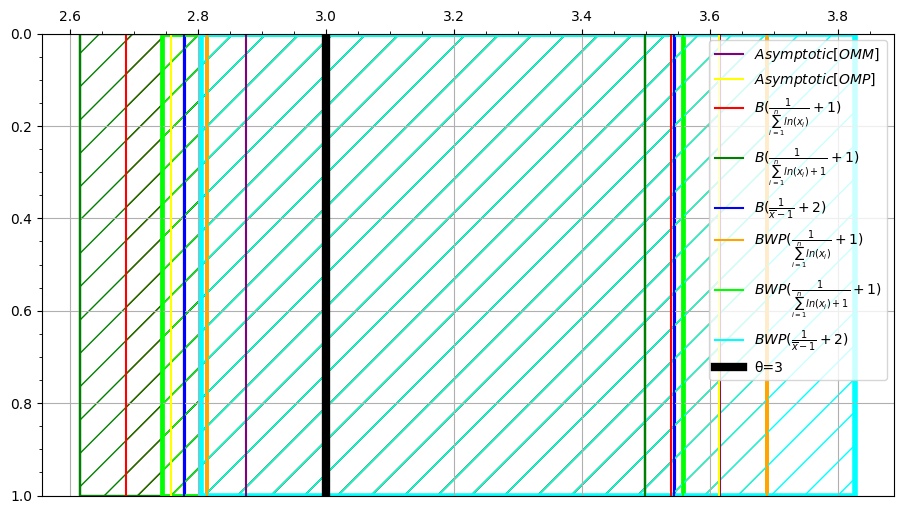

In [27]:
fig, ax = plt.subplots(figsize=(11, 6))

y_min, y_max = 0, 1

plt.ylim(y_min, y_max)
ax.minorticks_on()
ax.grid(which='major')

colors = ['purple', 'yellow', 'red', 'green', 'blue', 'orange', 'lime', 'cyan', 'fuchsia']
labels = ['Asymptotic[OMM]', 'Asymptotic[OMP]'] +\
         [f'B({formula})' for formula in n_est_formula] +\
         [f'BWP({formula})' for formula in n_est_formula]
labels += [f'θ={THETA}']
min_width, max_width = 0, 4
linewidths = np.linspace(min_width, max_width, len(all_intervals)-1)
y = [y_min, y_max]
for i, interv in enumerate(all_intervals[1:]):
    xi1=[interv[0], interv[0]]
    xi2=[interv[1], interv[1]]
    ax.plot(xi1, y, color=colors[i], label=fr'${labels[i]}$')
    ax.plot(xi2, y, color=colors[i])
    patch = patches.Rectangle((xi1[0], y[0]), xi2[0]-xi1[0], y[1], linewidth=linewidths[i], fill=None, hatch='/', color=colors[i])
    ax.add_patch(patch)

ax.plot((THETA, THETA), y, color='black', label=labels[-1], linewidth=max_width*1.5)

plt.gca().invert_yaxis()
plt.gca().axes.xaxis.set_ticks_position("top")
plt.legend()

fig1 = plt.gcf()
plt.show()

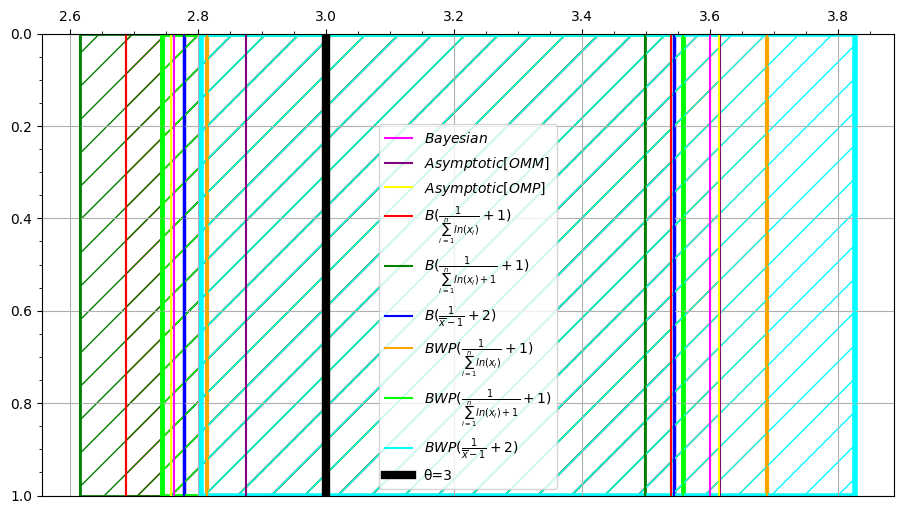

In [28]:
fig, ax = plt.subplots(figsize=(11, 6))

y_min, y_max = 0, 1

plt.ylim(y_min, y_max)
ax.minorticks_on()
ax.grid(which='major')

colors = ['fuchsia', 'purple', 'yellow', 'red', 'green', 'blue', 'orange', 'lime', 'cyan']
labels = ['Bayesian', 'Asymptotic[OMM]', 'Asymptotic[OMP]'] +\
         [f'B({formula})' for formula in n_est_formula] +\
         [f'BWP({formula})' for formula in n_est_formula]
labels += [f'θ={THETA}']
min_width, max_width = 0, 4
linewidths = np.linspace(min_width, max_width, len(all_intervals))

y = [y_min, y_max]

for i, interv in enumerate(all_intervals):
    xi1=[interv[0], interv[0]]
    xi2=[interv[1], interv[1]]
    ax.plot(xi1, y, color=colors[i], label=fr'${labels[i]}$')
    ax.plot(xi2, y, color=colors[i])
    patch = patches.Rectangle((xi1[0], y[0]), xi2[0]-xi1[0], y[1], linewidth=linewidths[i], fill=None, hatch='/', color=colors[i])
    ax.add_patch(patch)

ax.plot((THETA, THETA), y, color='black', label=labels[-1], linewidth=max_width*1.5)

plt.gca().invert_yaxis()
plt.gca().axes.xaxis.set_ticks_position("top")
plt.legend()

fig1 = plt.gcf()
plt.show()

fig1.savefig('Task_5_02', dpi=120)